In [1]:
# CARBON CREDITS ESTIMATION MODEL

In [2]:
# NEEDED LIBRARIES

import scipy.optimize as opt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# VARIABLES DECLARATION (to be changed for each project)

# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# DRC Biome Carbon Stock (tC/ha)

# FDHSH

FDHSH_ag = 195.69  # forêt dense humide sur sol hydromorphe - above the ground
FDHSH_bg = 112.21 * 0.5  # forêt dense humide sur sol hydromorphe - below ground (IPCC ratio 0.5)
FDHSH_pc = 1741.00  # forêt dense humide sur sol hydromorphe - peat carbon

# FDHTF

FDHTF_ag = 203.61  # forêt dense humide sur terre - above the ground
FDHTF_bg = 116.75 * 0.5  # forêt dense humide sur terre - below ground (IPCC ratio 0.5)
FDHTF_pc = 1741.00  # forêt dense humide sur terre - peat carbon

# FSFC

FSFC_ag = 66.76  # forêt sèche ou forêt claire - above the ground
FSFC_bg = 23.62 * 0.5  # forêt sèche ou forêt claire - below ground (IPCC ratio 0.5)
FSFC_pc = 0.00  # forêt sèche ou forêt claire - peat carbon

# FSc

FSc_ag = 111.49  # forêt secondaire - above the ground
FSc_bg = 63.93 * 0.5  # forêt secondaire - below ground (IPCC ratio 0.5)
FSc_pc = 0.00  # forêt secondaire - peat carbon

# AA

AA = 12.8  # anthropic area

# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# REDD AUD parameters

forest_area = 145700  # ha - at the year before beginning the project (later called y0)
start_year = 2022
conversion = 44 / 12  # conversion CO2/W

sfmp = False  # the project has a sustainable forest management plan (True - False)
fme = False  # forest management already ended (True - False)

cs_bg = FDHSH_bg  # carbon stock below ground
cs_ag = None # carbon stock above ground
if sfmp == 0:  
    cs_ag = FDHSH_ag  # if sfmp is False
elif fme == 0:
    cs_ag = FDHSH_ag * ((1 + 0.8377) / 2)  # if also fme is False
else: cs_ag = FDHSH_ag * 0.8377  # otherwise

adjustment = -0.1  # adjustment in the rate of deforestation in the next baselines (every 6 years)
issuance = 0.1  # yearly - project issuance beyond PMFS
leakage = 0.15  # yearly
buffer = 0.2  # retained - buffer considering SOCIALCARBON
uncertainties = 0.25 

hadr = None  # yearly - historical annual deforestation rate (later calculated)
no_name = None  # yearly - informar a variação anual de desmatamento (later calculated)

# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# others

avg_price = 7  # average price of REDD credit, usd/tCO2e
er = 5  # exchange rate usd/brl
avg_p_brl = avg_price * er  # average price in brl

In [4]:
# CALCULATING FROM EXCEL'S DATA SERIES

ds = pd.read_excel("data_series.xlsx", sheet_name='project_name')  # reads a certain sheet of the excel file
ds['annual_difference'] = ds['deforestation_(ha)'].pct_change().round(2)  # creates a column for percentage difference

# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# PREVIOUS DEFORESTATION CALCULATIONS

y0 = start_year - 1  # year before the beginning of the project
i = start_year - 10  # analysis initial year
analysed_per = (ds['year'] >= i) & (ds['year'] <= y0)  # analysed period

afy = ds.loc[(ds['year'] >= i) & (ds['year'] <= 2016), 'deforestation_(ha)'].mean().round(2)  # average first years
aly = ds.loc[(ds['year'] >= 2017) & (ds['year'] <= y0), 'deforestation_(ha)'].mean().round(2)  # average last years

deforestation_occ = ds.loc[analysed_per, 'deforestation_(ha)'].sum().round(2)  # deforestation occured so far
hadr = ((deforestation_occ / forest_area) / (y0 - i + 1)).round(5)  # yearly - historical annual deforestation rate
annual_incr = ((aly / afy) ** (1 / (y0 - i + 1)) - 1).round(3)  # annual increment
r_squared = (ds.loc[analysed_per, 'year'].corr(ds.loc[analysed_per, 'deforestation_(ha)']) ** 2).round(3)  # squared correlation coefficient
conference = afy * (1 + annual_incr) ** (y0 - i + 1)  # conference
no_name = annual_incr * r_squared  # yearly - informar a variação anual de desmatamento

ds['area_before'] = 0  # sets a new column for area before the project
ds['deforestation_wop'] = 0  # new column for deforestation without project
ds['area_wop'] = 0   # new column for area without project
ds['deforestation_wp'] = 0   # new column for deforestation without project
ds['area_wp'] = 0   # new column for area without project
ds['gross_reduction'] = 0   # gross emission reduction (tCOtwoe/year)
ds['project_em'] = 0   # project emissions (sustainable forest management and others) (tCO2e/year)
ds['discounted_reduction'] = 0   # reduction of emissions discounting project emissions (tCO2e/year)
ds['leakage'] = 0   
ds['buffer'] = 0   
ds['net_reduction'] = 0  # net emission reduction (tCO2e/year)

for n1 in range(i, start_year):  # calculates the forest areas before the projects
    if n1 == i:
        ds.loc[ds['year'] == n1, 'area_before'] = forest_area + ds.loc[(ds['year'] >= n1 + 1) & (ds['year'] <= y0), 'deforestation_(ha)'].sum().round(2)
    else:
        ds.loc[ds['year'] == n1, 'area_before'] = ds.loc[ds['year'] == n1 - 1, 'area_before'].values[0] - ds.loc[ds['year'] == n1, 'deforestation_(ha)'].sum().round(2)

# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# FUTURE DEFORESTATION CALCULATIONS       
        
ds.loc[ds['year'] == start_year, 'deforestation_wop'] = forest_area * hadr * (1 - uncertainties)  # calculates deforestation, year 0

for index, row in ds.iterrows():  # calculates deforestation, from year 1 to 5
    if start_year+1 <= row['year'] <= start_year+5:
        if no_name < 0:
            ds.at[index, 'deforestation_wop'] = ds.at[index - 1, 'deforestation_wop'] * (1 - no_name)
        elif no_name > 0:
            ds.at[index, 'deforestation_wop'] = ds.at[index - 1, 'deforestation_wop'] * (1 + no_name)
        else:
            ds.at[index, 'deforestation_wop'] = ds.at[index - 1, 'deforestation_wop']

if no_name < 0:  # calculates deforestation, year 6
    ds.loc[ds['year'] == start_year+6, 'deforestation_wop'] = ds.loc[(ds['year'] >= start_year) & (ds['year'] <= start_year+5), 'deforestation_wop'].mean() * (1 + adjustment) * (1 - no_name)
elif no_name > 0:
    ds.loc[ds['year'] == start_year+6, 'deforestation_wop'] = ds.loc[(ds['year'] >= start_year) & (ds['year'] <= start_year+5), 'deforestation_wop'].mean() * (1 + adjustment) * (1 + no_name)
else:
    ds.loc[ds['year'] == start_year+6, 'deforestation_wop'] = ds.loc[(ds['year'] >= start_year) & (ds['year'] <= start_year+5), 'deforestation_wop'].mean() * (1 + adjustment)

for index, row in ds.iterrows():  # calculates deforestation, from year 7 to 11
    if start_year+7 <= row['year'] <= start_year+11:
        if no_name < 0:
            ds.at[index, 'deforestation_wop'] = ds.at[index - 1, 'deforestation_wop'] * (1 - no_name)
        elif no_name > 0:
            ds.at[index, 'deforestation_wop'] = ds.at[index - 1, 'deforestation_wop'] * (1 + no_name)
        else:
            ds.at[index, 'deforestation_wop'] = ds.at[index - 1, 'deforestation_wop']
            
if no_name < 0:  # calculates deforestation, year 12
    ds.loc[ds['year'] == start_year+12, 'deforestation_wop'] = ds.loc[(ds['year'] >= start_year+6) & (ds['year'] <= start_year+11), 'deforestation_wop'].mean() * (1 + adjustment) * (1 - no_name)
elif no_name > 0:
    ds.loc[ds['year'] == start_year+12, 'deforestation_wop'] = ds.loc[(ds['year'] >= start_year+6) & (ds['year'] <= start_year+11), 'deforestation_wop'].mean() * (1 + adjustment) * (1 + no_name)
else:
    ds.loc[ds['year'] == start_year+12, 'deforestation_wop'] = ds.loc[(ds['year'] >= start_year+6) & (ds['year'] <= start_year+11), 'deforestation_wop'].mean() * (1 + adjustment)

for index, row in ds.iterrows():  # calculates deforestation, from year 13 to 17
    if start_year+13 <= row['year'] <= start_year+17:
        if no_name < 0:
            ds.at[index, 'deforestation_wop'] = ds.at[index - 1, 'deforestation_wop'] * (1 - no_name)
        elif no_name > 0:
            ds.at[index, 'deforestation_wop'] = ds.at[index - 1, 'deforestation_wop'] * (1 + no_name)
        else:
            ds.at[index, 'deforestation_wop'] = ds.at[index - 1, 'deforestation_wop']
            
if no_name < 0:  # calculates deforestation, year 18
    ds.loc[ds['year'] == start_year+18, 'deforestation_wop'] = ds.loc[(ds['year'] >= start_year+12) & (ds['year'] <= start_year+17), 'deforestation_wop'].mean() * (1 + adjustment) * (1 - no_name)
elif no_name > 0:
    ds.loc[ds['year'] == start_year+18, 'deforestation_wop'] = ds.loc[(ds['year'] >= start_year+12) & (ds['year'] <= start_year+17), 'deforestation_wop'].mean() * (1 + adjustment) * (1 + no_name)
else:
    ds.loc[ds['year'] == start_year+18, 'deforestation_wop'] = ds.loc[(ds['year'] >= start_year+12) & (ds['year'] <= start_year+17), 'deforestation_wop'].mean() * (1 + adjustment)

for index, row in ds.iterrows():  # calculates deforestation, from year 19 to 23
    if start_year+19 <= row['year'] <= start_year+23:
        if no_name < 0:
            ds.at[index, 'deforestation_wop'] = ds.at[index - 1, 'deforestation_wop'] * (1 - no_name)
        elif no_name > 0:
            ds.at[index, 'deforestation_wop'] = ds.at[index - 1, 'deforestation_wop'] * (1 + no_name)
        else:
            ds.at[index, 'deforestation_wop'] = ds.at[index - 1, 'deforestation_wop']
            
if no_name < 0:  # calculates deforestation, year 24
    ds.loc[ds['year'] == start_year+24, 'deforestation_wop'] = ds.loc[(ds['year'] >= start_year+18) & (ds['year'] <= start_year+23), 'deforestation_wop'].mean() * (1 + adjustment) * (1 - no_name)
elif no_name > 0:
    ds.loc[ds['year'] == start_year+24, 'deforestation_wop'] = ds.loc[(ds['year'] >= start_year+18) & (ds['year'] <= start_year+23), 'deforestation_wop'].mean() * (1 + adjustment) * (1 + no_name)
else:
    ds.loc[ds['year'] == start_year+24, 'deforestation_wop'] = ds.loc[(ds['year'] >= start_year+18) & (ds['year'] <= start_year+23), 'deforestation_wop'].mean() * (1 + adjustment)

for index, row in ds.iterrows():  # calculates deforestation, from year 25 to 29
    if start_year+25 <= row['year'] <= start_year+29:
        if no_name < 0:
            ds.at[index, 'deforestation_wop'] = ds.at[index - 1, 'deforestation_wop'] * (1 - no_name)
        elif no_name > 0:
            ds.at[index, 'deforestation_wop'] = ds.at[index - 1, 'deforestation_wop'] * (1 + no_name)
        else:
            ds.at[index, 'deforestation_wop'] = ds.at[index - 1, 'deforestation_wop']
            
for n1 in range(start_year, ds['year'].max()+1):  # calculates the forest areas following the baseline scenario
    if n1 == start_year:
        ds.loc[ds['year'] == n1, 'area_wop'] = ds.loc[ds['year'] == n1 - 1, 'area_before'].values[0] - ds.loc[ds['year'] == n1, 'deforestation_wop'].values[0]
    else:
        ds.loc[ds['year'] == n1, 'area_wop'] = ds.loc[ds['year'] == n1 - 1, 'area_wop'].values[0] - ds.loc[ds['year'] == n1, 'deforestation_wop'].values[0]   
        
# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# EMISSIONS CALCULATIONS

for n1 in range(start_year, ds['year'].max()+1):  # calculates gross emission reduction
    if n1 == start_year:
        ds.loc[ds['year'] == n1, 'gross_reduction'] = ds.loc[ds['year'] == n1, 'deforestation_wop'].values[0] * conversion * (cs_ag + cs_bg / 10)
    else:
        ds.loc[ds['year'] == n1, 'gross_reduction'] = conversion * ( ds.loc[ds['year'] == n1, 'deforestation_wop'].values[0] * cs_ag + cs_bg * ds.loc[(ds['year'] >= start_year) & (ds['year'] <= n1), 'deforestation_(ha)'].sum() / 10 - AA * ds.loc[(ds['year'] >= start_year) & (ds['year'] <= n1 - 1), 'deforestation_(ha)'].sum() / 9 )

for n1 in range(start_year, ds['year'].max()+1):  # calculates project emissions
    if n1 == start_year:
        ds.loc[ds['year'] == n1, 'project_em'] = ds.loc[ds['year'] == n1, 'gross_reduction'].values[0] * issuance
    else:
        ds.loc[ds['year'] == n1, 'project_em'] = ds.loc[ds['year'] == n1-1, 'gross_reduction'].values[0] * issuance
        
for n1 in range(start_year, ds['year'].max()+1):  # calculates reduction of emissions discounting project emissions     
    ds.loc[ds['year'] == n1, 'discounted_reduction'] = ds.loc[ds['year'] == n1, 'gross_reduction'].values[0] - ds.loc[ds['year'] == n1, 'project_em'].values[0]
    
for n1 in range(start_year, ds['year'].max()+1):  # calculates reduction of emissions discounting project emissions     
    ds.loc[ds['year'] == n1, 'leakage'] = ds.loc[ds['year'] == n1, 'gross_reduction'].values[0] * leakage
    
for n1 in range(start_year, ds['year'].max()+1):  # calculates reduction of emissions discounting project emissions     
    ds.loc[ds['year'] == n1, 'buffer'] = ds.loc[ds['year'] == n1, 'gross_reduction'].values[0] * buffer
    
for n1 in range(start_year, ds['year'].max()+1):  # calculates reduction of emissions discounting project emissions     
    ds.loc[ds['year'] == n1, 'net_reduction'] = ds.loc[ds['year'] == n1, 'discounted_reduction'].values[0] - ds.loc[ds['year'] == n1, 'leakage'].values[0] - ds.loc[ds['year'] == n1, 'buffer'].values[0]
        
tot_net_red = ds.loc[(ds['year'] >= start_year) & (ds['year'] <= ds['year'].max()), 'net_reduction'].sum()  # total over 30 years (tCO2e)
avg_net_red = ds.loc[(ds['year'] >= start_year) & (ds['year'] <= ds['year'].max()), 'net_reduction'].mean()  # average/year (tCO2e/year)
tot_rev = tot_net_red * avg_p_brl  # total revenues in 30 years in brl
avg_rev = avg_net_red * avg_p_brl  # average revenues in thirty years per year in brl
tot_def_wop = forest_area - ds.loc[(ds['year'] == ds['year'].max()), 'area_wop'].values[0].round(0)  # total deforestation in 30 years in ha
def_wop_ratio = round((1 - ds.loc[(ds['year'] == ds['year'].max()), 'area_wop'].values[0].round(0) / forest_area) * 100, 1)  # percentage of deforestation in 30 years

ds['deforestation_wop'] = ds['deforestation_wop'].round(0)
ds['area_wop'] = ds['area_wop'].round(0)
ds['gross_reduction'] = ds['gross_reduction'].round(0)
ds['project_em'] = ds['project_em'].round(0)
ds['discounted_reduction'] = ds['discounted_reduction'].round(0)
ds['leakage'] = ds['leakage'].round(0)
ds['buffer'] = ds['buffer'].round(0)
ds['net_reduction'] = ds['net_reduction'].round(0)
ds['area_wp'] = ds['area_wp'].round(0)

for index, row in ds.iterrows():  
    if start_year <= row['year'] <= ds['year'].max():
        ds.at[index, 'deforestation_wp'] = ds.at[index, 'project_em'] * (1 - no_name) / (conversion * cs_ag)
ds['deforestation_wp'] = ds['deforestation_wp'].round(0)

for n1 in range(start_year, ds['year'].max()+1):  # calculates the forest areas following the project scenario
    if n1 == start_year:
        ds.loc[ds['year'] == n1, 'area_wp'] = ds.loc[ds['year'] == n1 - 1, 'area_before'].values[0] - ds.loc[ds['year'] == n1, 'deforestation_wp'].values[0]
    else:
        ds.loc[ds['year'] == n1, 'area_wp'] = ds.loc[ds['year'] == n1 - 1, 'area_wp'].values[0] - ds.loc[ds['year'] == n1, 'deforestation_wp'].values[0] 

ds.replace(0, np.nan, inplace=True)
ds

C:\Users\HP\AppData\Local\Temp\ipykernel_5464\3229571459.py:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ds['annual_difference'] = ds['deforestation_(ha)'].pct_change().round(2)  # creates a column for percentage difference
C:\Users\HP\AppData\Local\Temp\ipykernel_5464\3229571459.py:44: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '503.75775' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ds.loc[ds['year'] == start_year, 'deforestation_wop'] = forest_area * hadr * (1 - uncertainties)  # calculates deforestation, year 0
C:\Users\HP\AppData\Local\Temp\ipykernel_5464\3229571459.py:121: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future

,year,deforestation_(ha),annual_difference,area_before,deforestation_wop,area_wop,deforestation_wp,area_wp,gross_reduction,project_em,discounted_reduction,leakage,buffer,net_reduction
0,2010,640.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011,299.0,-0.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2012,166.0,-0.44,152258.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013,660.0,2.98,151598.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014,713.0,0.08,150885.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2015,450.0,-0.37,150435.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2016,1050.0,1.33,149385.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2017,593.0,-0.44,148792.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2018,623.0,0.05,148169.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2019,912.0,0.46,147257.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<function matplotlib.pyplot.show(close=None, block=None)>

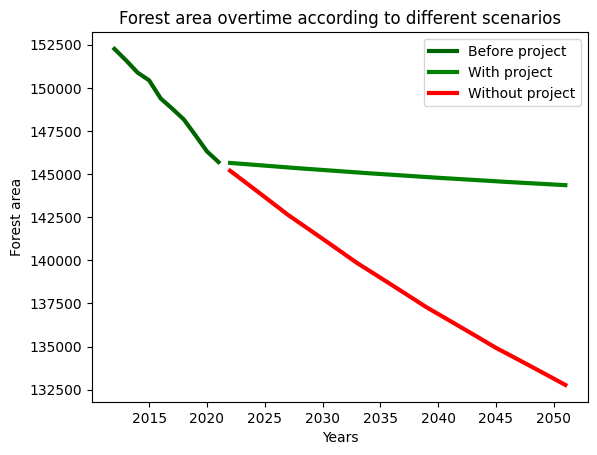

In [5]:
# VISUALIZATION 1

plt.plot(ds['year'], ds['area_before'], label='Before project', color='darkgreen', linewidth=3)
plt.plot(ds['year'], ds['area_wp'], label='With project', color='green', linewidth=3)
plt.plot(ds['year'], ds['area_wop'], label='Without project', color='red', linewidth=3)
plt.xlabel('Years')
plt.ylabel('Forest area')
plt.legend()
plt.title('Forest area overtime according to different scenarios')
plt.show

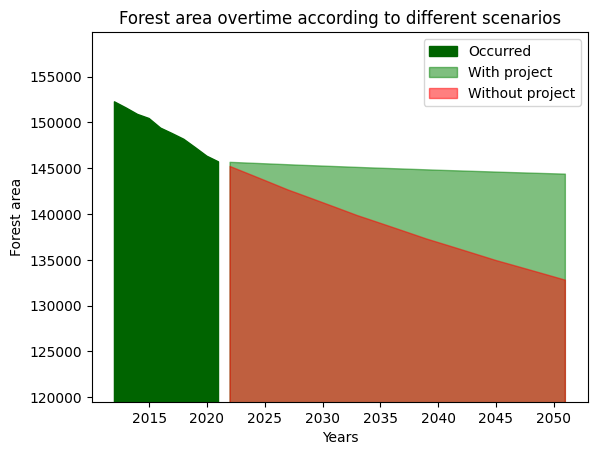

In [6]:
# VISUALIZATION 2

fig, ax = plt.subplots()
ax.fill_between(ds['year'], ds['area_before'], color='darkgreen', label='Occurred')
ax.fill_between(ds['year'], ds['area_wp'], color='green', alpha=0.5, label='With project')
ax.fill_between(ds['year'], ds['area_wop'], color='red', alpha=0.5, label='Without project')
ax.set_xlabel('Years')
ax.set_ylabel('Forest area')
ax.set_title('Forest area overtime according to different scenarios')
bttm=(ds.loc[ds['year'] == ds['year'].max(), 'area_wop'].values[0])*0.9
ax.set_ylim(bottom=bttm)
ax.legend()
plt.show()